In [27]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from itertools import islice
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


# stylometria

# Wykresy ze średnią różnicą między płciami we wszystkich cechach per model. 
# Poprawki do dotychczasowych wykresów - wywalić male z histogramów. 
# Ten drugi wykres ze zestandaryzowanymi różnicami zrobić pionowym, pokolorować na niebiesko / różowo na podstawie znaku różnicy. 
# Oprócz tego wyciągnąć przykłady kilku wypowiedzi, gdzie te cechy się diametralnie różniły pomiędzy płciami.

In [3]:
PVALUE = 0.05

In [4]:
df = pd.read_csv('./data/llms_dark_patterns_claude_sonnet_3_5.csv', decimal=',')

In [5]:
variables_cols = list(df.columns[1:6])
variables_cols

['level', 'trait', 'belief', 'question', 'type']

In [6]:
text_feature_cols = list(df.columns[24:])
len(text_feature_cols)

86

In [7]:
female_df = df[df['gender'] == "female"][text_feature_cols].astype('float')
male_df = df[df['gender'] == "male"][text_feature_cols].astype('float')

In [8]:
wilcoxon_pvalues = dict()

for feature in text_feature_cols:
    res = wilcoxon(np.array(female_df[feature]), np.array(male_df[feature]), alternative='two-sided')
    wilcoxon_pvalues[feature] = res.pvalue

/home/wpartycja/.local/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


In [9]:
wilcoxon_pvalues

{'WC': 6.93978597911611e-37,
 'Analytic': 8.210995449109782e-05,
 'Clout': 1.5451591550712232e-13,
 'Authentic': 0.5981824538073935,
 'Tone': nan,
 'WPS': 0.3758600077576397,
 'BigWords': 0.1556413819387301,
 'pronoun_LIWC': 0.025030000985840847,
 'ppron': 7.93834947338073e-06,
 'i': 0.0004627494458763329,
 'we': 9.471692299293092e-06,
 'you': 4.5680882681719083e-10,
 'shehe': 0.9911039394200624,
 'they': 0.44150709642396524,
 'ipron': 0.2522891098873453,
 'det': 0.2216020073247844,
 'article': 5.171681277533437e-09,
 'number': 6.790582139493202e-11,
 'prep': 0.07088938869683856,
 'auxverb': 1.1037545244622043e-10,
 'adverb': 4.8325154429115944e-08,
 'conj': 2.0345209223242916e-09,
 'negate': 1.1908720019636869e-07,
 'verb': 4.283458507918561e-18,
 'adj': 9.569608179477282e-05,
 'Drives': 0.5532800721566971,
 'affiliation': 0.007863060913816057,
 'achieve': 0.1595613049609672,
 'power': 0.2967232378195721,
 'Cognition': 3.5365779032035375e-08,
 'allnone': 0.2859091545125556,
 'cogproc'

In [10]:
# sort
wilcoxon_pvalues = {feature: pvalue for feature, pvalue in sorted(wilcoxon_pvalues.items(), key=lambda item: item[1])}

# categorize
wilcoxon_pvalues_0_05 = {feature: pvalue for feature, pvalue in wilcoxon_pvalues.items() if pvalue < PVALUE}
wilcoxon_pvalues_0_95 = {feature: pvalue for feature, pvalue in wilcoxon_pvalues.items() if pvalue >= PVALUE}

In [11]:
len(wilcoxon_pvalues_0_05)

49

In [12]:
top_10_diff_featrues = [feature for feature, number in zip(wilcoxon_pvalues_0_05.keys(), range(10))]

/tmp/ipykernel_1502/2663013886.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(female_df[col], label=f'female', fill=True, alpha=0.5, ax=ax, color='hotpink')


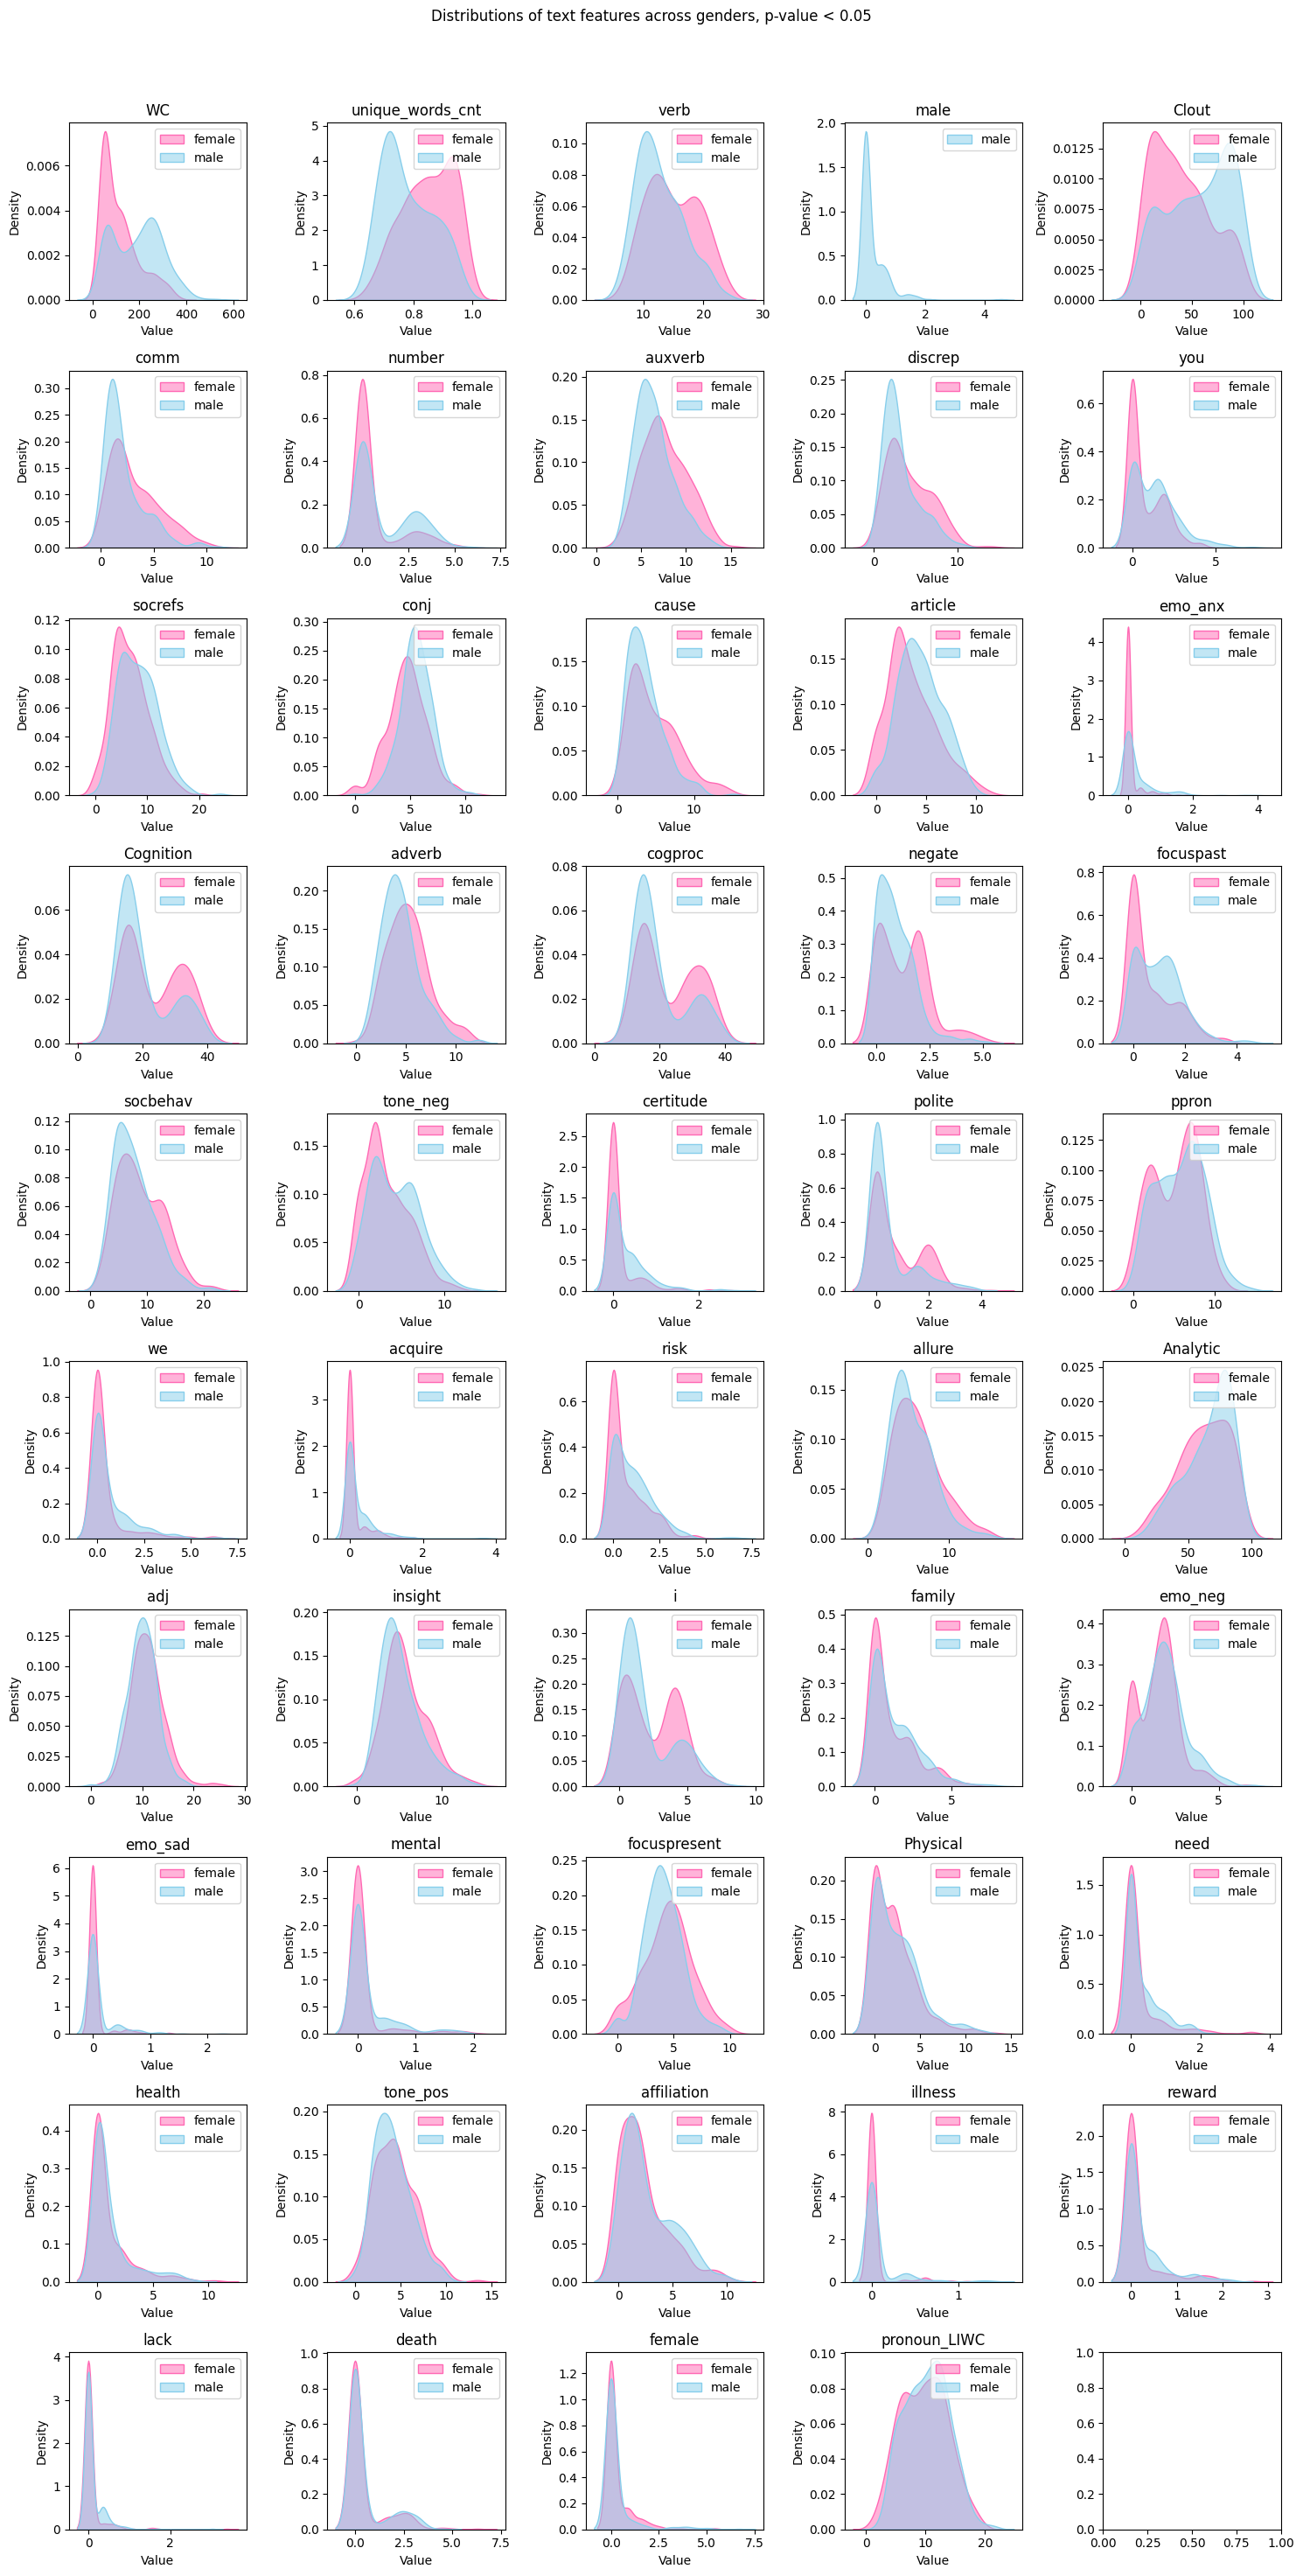

In [13]:
fig, axes = plt.subplots(10, 5, figsize=(15, 30))
fig.suptitle(f'Distributions of text features across genders, p-value < {PVALUE}')


for ax, col in zip(axes.flat, wilcoxon_pvalues_0_05.keys()):
    sns.kdeplot(female_df[col], label=f'female', fill=True, alpha=0.5, ax=ax, color='hotpink')
    sns.kdeplot(male_df[col], label=f'male', fill=True, alpha=0.5, ax=ax, color='skyblue')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(f'{col}')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/tmp/ipykernel_1502/2183820430.py:4: RuntimeWarning: invalid value encountered in scalar divide
  col: mean_differences[col] / (max(female_df[col].max(), male_df[col].max()) - min(female_df[col].min(), male_df[col].min()))


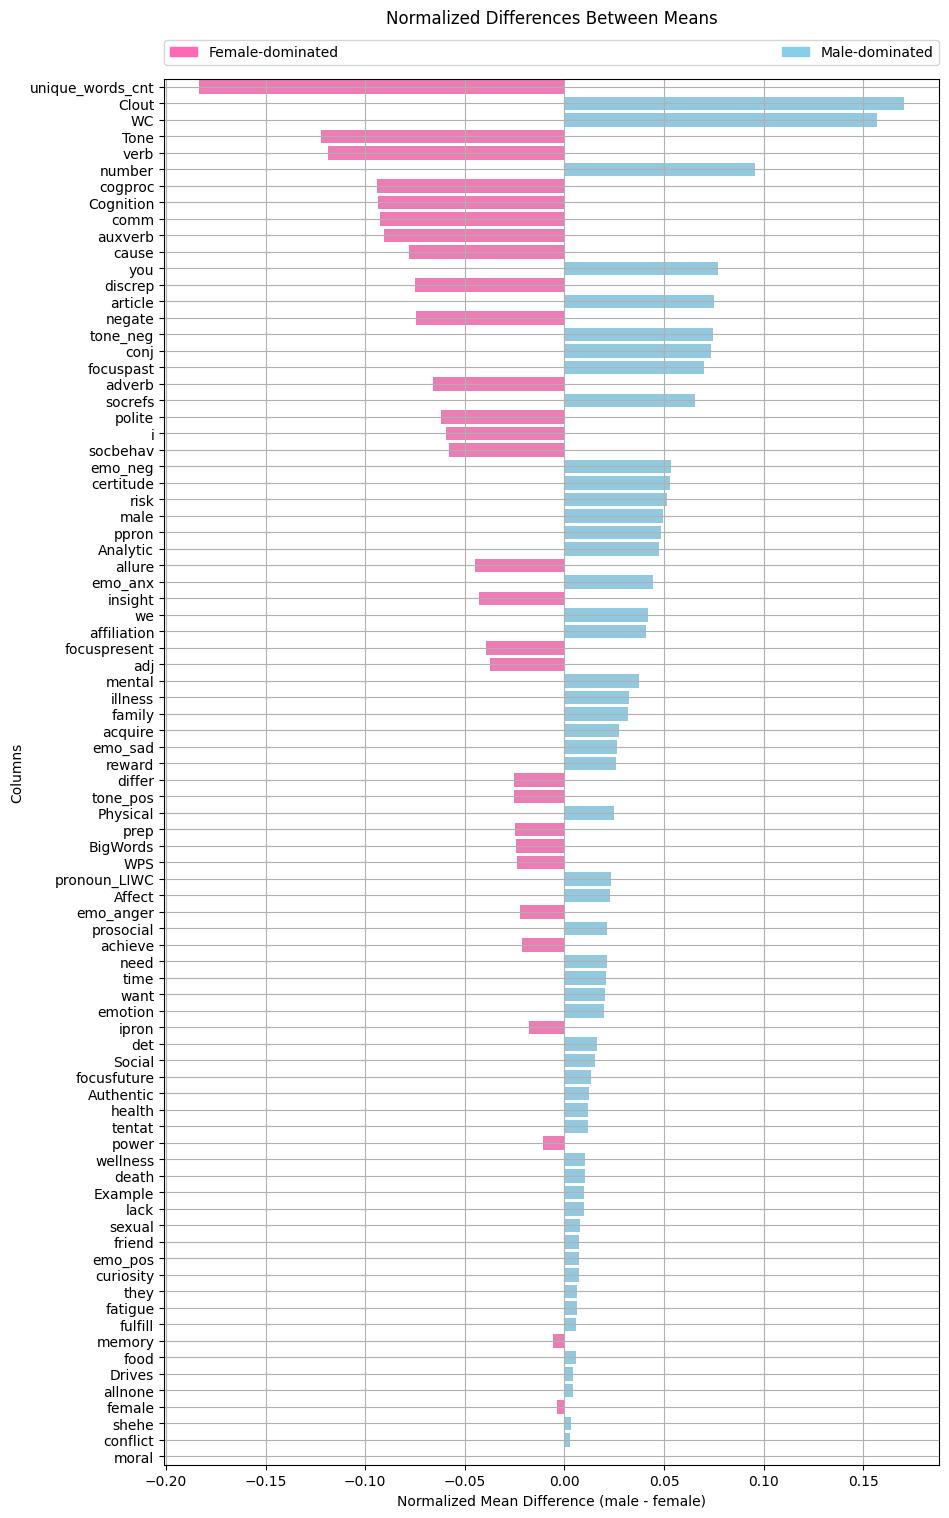

In [ ]:
# Compute mean differences
mean_differences = {col: male_df[col].mean() - female_df[col].mean() for col in text_feature_cols}
normalized_differences = {
    col: mean_differences[col] / (max(female_df[col].max(), male_df[col].max()) - min(female_df[col].min(), male_df[col].min()))
    for col in mean_differences
}

# Sort by absolute value
sorted_means = dict(
    sorted(
        {k: v for k, v in normalized_differences.items() if not pd.isna(v)}.items(),
        key=lambda item: abs(item[1]),
        reverse=True
    )
)
colors = ['skyblue' if val > 0 else 'hotpink' for val in sorted_means.values()]


# Create figure and plot
fig, ax = plt.subplots(figsize=(10, 18))
sns.barplot(y=list(sorted_means.keys()), x=list(sorted_means.values()), hue=list(sorted_means.keys()), palette=colors, ax=ax)

# Set labels and title
ax.set_ylabel('Columns')
ax.set_xlabel('Normalized Mean Difference (male - female)')
ax.set_title('Normalized Differences Between Means')
# ax.grid()

# Add legend between title and plot
legend_patches = [
    mpatches.Patch(color='hotpink', label='Female-dominated'),
    mpatches.Patch(color='skyblue', label='Male-dominated'),
]

ax.legend(
    handles=legend_patches,
    loc='lower left',
    mode='expand',
    borderaxespad=0.,
    ncol=2,
    bbox_to_anchor=(0., 1.01, 1., .102)
)

# Set title below the legend
ax.set_title('Normalized Differences Between Means', pad=40)

plt.show()